In [ ]:
# loading a library
import pandas as pd

In [ ]:
# reading a dataset
df = pd.read_excel('/content/aws.xlsx')

In [ ]:
# dropping the unnecessary columns
df.drop(columns=['small','ui','ui1','ui2','ui3','small1','tiptextwrap','score-description','review-date','small2','review-profile-defined','score-description1','small3','review-copy-sub-header','small4'], inplace=True)

In [ ]:
# converting all reviews from different columns to one column
reviews = df.stack().reset_index()[0]

In [ ]:
# Removing unnecessary words
reviews = reviews[~reviews.str.contains('Pros') & ~reviews.str.contains('Cons')]

In [ ]:
reviews

0                                                    0.0
1                                     AWS we love Lambda
2                                                    1.0
3      Multiple locations and databases . Some servic...
4                                                    3.0
                             ...                        
321                            Great Cloud Based Service
322                                                244.0
323    Adding AWS allows for my company to use and ma...
324                                                246.0
325    You get what you pay for. Obviously the price ...
Name: 0, Length: 326, dtype: object

In [ ]:
# saving cleaned data for future use
reviews.to_csv('/content/aws.csv')

In [ ]:
# load spaCy library
import spacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Load contractions library
import contractions

In [ ]:
# load nltk library
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# define vader senitment intensity analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Finding aspects and polarity score

In [ ]:
aspects = []
descriptive_term = ''
target = ''

# iterate through each review
for review in reviews:
  expanded_words = []

  for word in review.split():
    # Word Contraction Expansion
    expanded_words.append(contractions.fix(word))     # using contractions.fix to expand the shortened words

  expanded_text = ' '.join(expanded_words)
  doc = nlp(expanded_text.lower())                    # Case folding to lower case
  
  for sent in doc.sents:                              # Sentence Segmentation
    sent_lemma = nlp(sent.lemma_)
    for token in sent_lemma:                          # Lemmatization
      # POS (part-of-speech) tagging
      if token.dep_ == 'nsubj' and token.pos_ == 'NOUN':
        target = token.text
      if token.pos_ == 'ADJ':
        prepend = ''
        for child in token.children:
          if child.pos_ != 'ADV':
            continue
          prepend += child.text + ' '
        descriptive_term = prepend + token.text  
        if target != '':  
          polarity_scores = sia.polarity_scores(sent_lemma.text)      # Sentiment polarity
          sentiment = 'positive' if polarity_scores['compound'] > 0 else 'negative' if polarity_scores['compound'] < 0 else 'neutral'   # Assigning sentiment according to score
          aspects.append({'aspect': target,
                        'description': descriptive_term,
                        'compound_polarity': polarity_scores['compound'],
                        'sentiment': sentiment})    # save it in the list

In [ ]:
# convert the output list into the csv file
pd.DataFrame(aspects).to_csv('/content/aspect_vader_result.csv')

Using Textblob instead of Vader

In [ ]:
from textblob import TextBlob

In [ ]:
aspects = []
descriptive_term = ''
target = ''

for review in reviews:
  expanded_words = []

  for word in review.split():
    expanded_words.append(contractions.fix(word))

  expanded_text = ' '.join(expanded_words)
  doc = nlp(expanded_text.lower())
  
  for sent in doc.sents:
    for token in sent:
      if token.dep_ == 'nsubj' and token.pos_ == 'NOUN':
        target = token.text
      if token.pos_ == 'ADJ':
        prepend = ''
        for child in token.children:
          if child.pos_ != 'ADV':
            continue
          prepend += child.text + ' '
        descriptive_term = prepend + token.text  
        if target != '':
          polarity_scores = TextBlob(sent.text).polarity    # Everything else is same except here
          sentiment = 'positive' if polarity_scores > 0 else 'negative' if polarity_scores < 0 else 'neutral'
          aspects.append({'aspect': target,
                        'description': descriptive_term,
                        'polarity_score': polarity_scores,
                        'sentiment': sentiment})

In [ ]:
pd.DataFrame(aspects).to_csv('/content/aspect_textblob_result.csv')

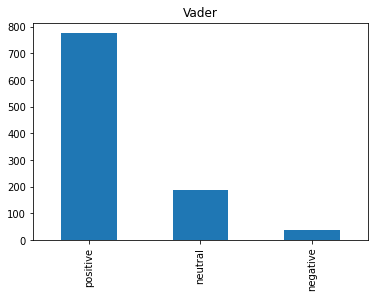

In [ ]:
df_vader = pd.read_csv('/content/aspect_vader_result.csv')
df_vader['sentiment'].value_counts().plot(kind='bar', title = 'Vader')

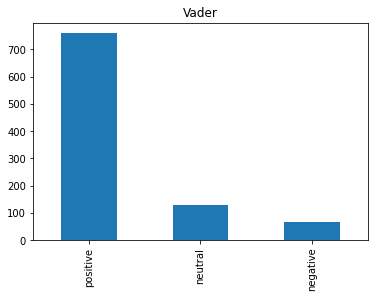

In [ ]:
df_textblob = pd.read_csv('/content/aspect_textblob_result.csv')
df_textblob['sentiment'].value_counts().plot(kind='bar', title = 'Vader')

In [ ]:
print(df_vader['sentiment'].value_counts())

positive    776
neutral     188
negative     38
Name: sentiment, dtype: int64


In [ ]:
df_textblob['sentiment'].value_counts()

positive    760
neutral     130
negative     68
Name: sentiment, dtype: int64

In [ ]:
df_vader.groupby(by = 'aspect')['compound_polarity'].mean().to_csv("output.csv")